In [ ]:
# 2025-4-20 run it in "pytohn 3 base env" on ins-gl-pt-gpu24-2c94136-3env-j4-l4-test-1 with 1 L4 GPU


# CubeDiff: Model Architecture

This notebook demonstrates the CubeDiff model architecture implementation:

1. Load pretrained Stable Diffusion model
2. Implement inflated attention layers
3. Implement synchronized group normalization
4. Add positional encodings
5. Apply LoRA for efficient fine-tuning
6. Test the complete model architecture

In [1]:
import os
import sys
import numpy as np
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt

# Add parent directory to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import custom modules
from model.attention import inflate_attention_layer, InflatedAttention
from model.normalization import SynchronizedGroupNorm, replace_group_norms
from model.positional_encoding import CubemapPositionalEncoding
from model.architecture import CubeDiffModel
from training.lora import LoRALayer, add_lora_to_model

## 1. Load Pretrained Stable Diffusion Model

In [2]:
%%time
# Load pretrained Stable Diffusion pipeline
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# Extract components
unet = pipeline.unet
vae = pipeline.vae
text_encoder = pipeline.text_encoder
tokenizer = pipeline.tokenizer

# Move to CPU to save GPU memory during testing
unet = unet.to("cpu")
vae = vae.to("cpu")
text_encoder = text_encoder.to("cpu")

print(f"UNet parameters: {sum(p.numel() for p in unet.parameters()):,}")
print(f"VAE parameters: {sum(p.numel() for p in vae.parameters()):,}")
print(f"Text Encoder parameters: {sum(p.numel() for p in text_encoder.parameters()):,}")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


UNet parameters: 859,520,964
VAE parameters: 83,653,863
Text Encoder parameters: 123,060,480
CPU times: user 3.18 s, sys: 2.02 s, total: 5.21 s
Wall time: 1.63 s


## 2. Test Inflated Attention Implementation

In [3]:
%%time
# Get a sample attention layer from UNet
sample_attn = None
for name, module in unet.named_modules():
    if 'attn' in name and hasattr(module, 'to_q'):
        sample_attn = module
        print(f"Found attention layer: {name}")
        break

# Test inflated attention layer
inflated_attn = inflate_attention_layer(sample_attn)

# Test forward pass
batch_size = 2
num_faces = 6
seq_len = 16
hidden_dim = sample_attn.to_q.in_features

# Create test input
test_input = torch.randn(batch_size, num_faces, seq_len, hidden_dim)
test_context = torch.randn(batch_size, num_faces, seq_len, hidden_dim)

# Run forward pass
with torch.no_grad():
    output = inflated_attn(test_input, test_context)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
assert output.shape == test_input.shape, "Output shape doesn't match input shape"

Found attention layer: down_blocks.0.attentions.0.transformer_blocks.0.attn1
Input shape: torch.Size([2, 6, 16, 320])
Output shape: torch.Size([2, 6, 16, 320])
CPU times: user 23.2 ms, sys: 10.2 ms, total: 33.4 ms
Wall time: 8.45 ms


## 3. Test Synchronized Group Normalization

In [4]:
%%time
# Get a sample GroupNorm layer from UNet
sample_gn = None
for name, module in unet.named_modules():
    if isinstance(module, torch.nn.GroupNorm):
        sample_gn = module
        print(f"Found GroupNorm layer: {name}")
        print(f"  num_groups: {module.num_groups}")
        print(f"  num_channels: {module.num_channels}")
        break

# Create synchronized GroupNorm
synced_gn = SynchronizedGroupNorm(
    num_groups=sample_gn.num_groups,
    num_channels=sample_gn.num_channels,
    eps=sample_gn.eps,
    affine=sample_gn.affine
)

# Copy weights
if sample_gn.affine:
    synced_gn.weight.data.copy_(sample_gn.weight.data)
    synced_gn.bias.data.copy_(sample_gn.bias.data)

# Test forward pass
batch_size = 2
num_faces = 6
channels = sample_gn.num_channels
height = 32
width = 32

# Create test input
test_input = torch.randn(batch_size, num_faces, channels, height, width)

# Run forward pass
with torch.no_grad():
    output = synced_gn(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
assert output.shape == test_input.shape, "Output shape doesn't match input shape"

# Test replacing all GroupNorm layers
small_test_model = torch.nn.Sequential(
    torch.nn.GroupNorm(32, 128),
    torch.nn.Conv2d(128, 128, 3, 1, 1),
    torch.nn.GroupNorm(32, 128),
    torch.nn.Conv2d(128, 256, 3, 1, 1),
    torch.nn.GroupNorm(32, 256)
)

modified_model = replace_group_norms(small_test_model, in_place=False)

# Check if GroupNorm layers were replaced
for name, module in modified_model.named_modules():
    if isinstance(module, (torch.nn.GroupNorm, SynchronizedGroupNorm)):
        print(f"Layer {name}: {type(module).__name__}")

Found GroupNorm layer: down_blocks.0.attentions.0.norm
  num_groups: 32
  num_channels: 320
Input shape: torch.Size([2, 6, 320, 32, 32])
Output shape: torch.Size([2, 6, 320, 32, 32])
Layer 0: SynchronizedGroupNorm
Layer 2: SynchronizedGroupNorm
Layer 4: SynchronizedGroupNorm
CPU times: user 140 ms, sys: 54.5 ms, total: 195 ms
Wall time: 69.8 ms


## 4. Test Positional Encoding

Input shape: torch.Size([2, 6, 4, 64, 64])
Output shape: torch.Size([2, 6, 6, 64, 64])
Added 2 positional encoding channels


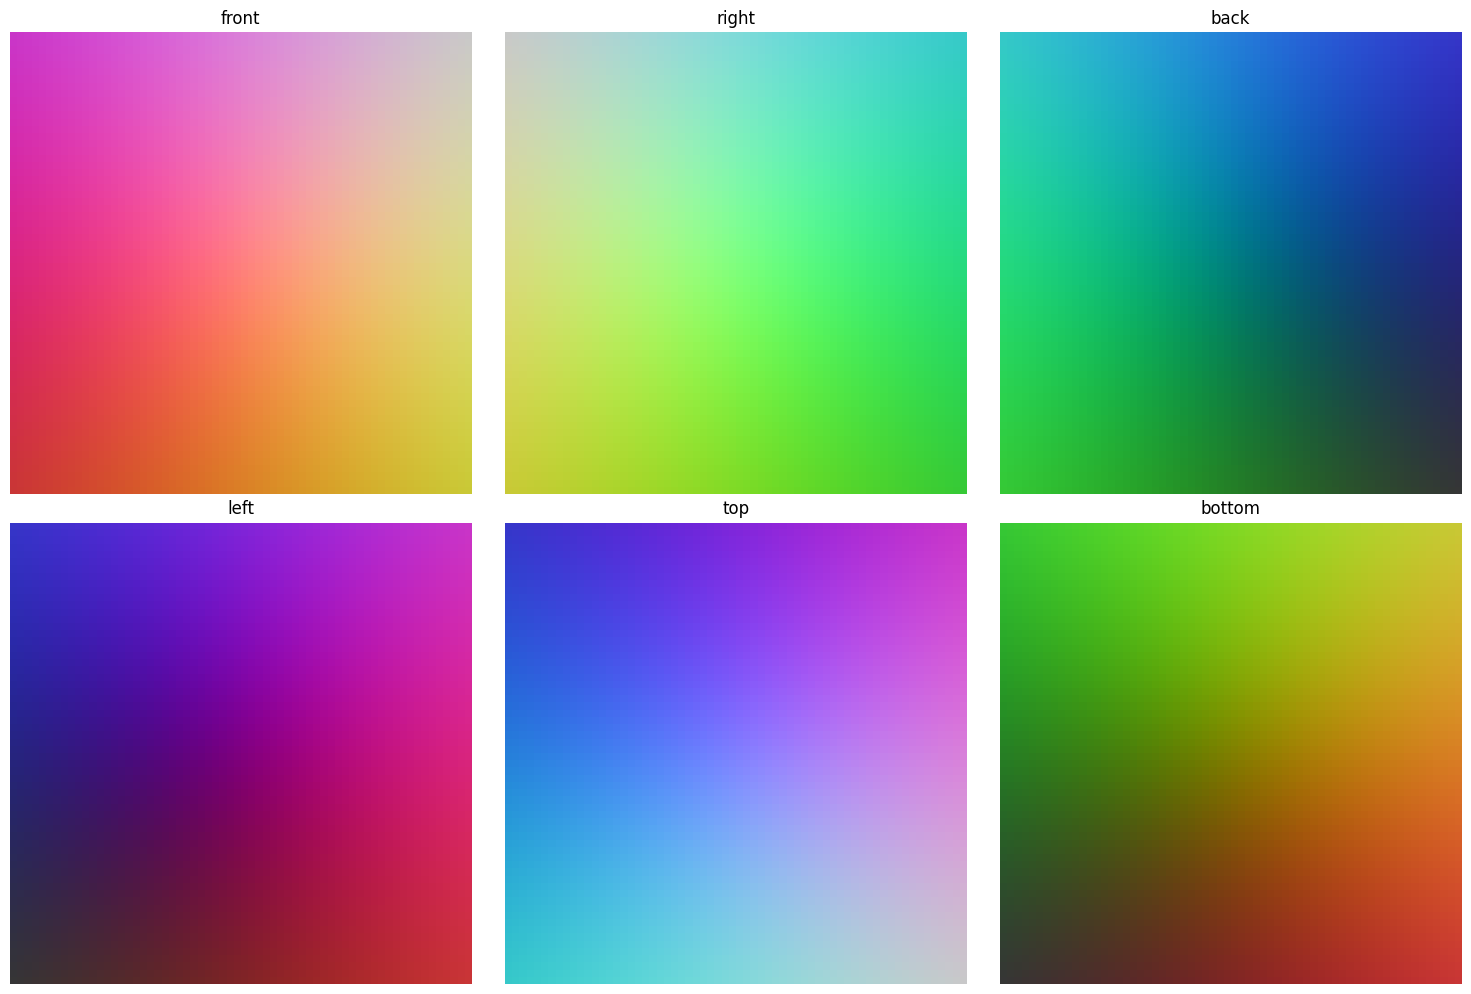

In [5]:
# Create positional encoding module
pos_enc = CubemapPositionalEncoding(embedding_dim=4, max_resolution=64)

# Test forward pass
batch_size = 2
num_faces = 6
channels = 4
height = 64
width = 64

# Create test input
test_input = torch.randn(batch_size, num_faces, channels, height, width)

# Run forward pass
output = pos_enc(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Added {output.shape[2] - test_input.shape[2]} positional encoding channels")

# Visualize the positional encoding
face_coords = pos_enc.face_coords.cpu().numpy()

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
face_names = ['front', 'right', 'back', 'left', 'top', 'bottom']

for i, face_name in enumerate(face_names):
    row, col = i // 3, i % 3
    # Visualize the x coordinate as RGB
    rgb = face_coords[i, :, :, :3] * 0.5 + 0.5
    axs[row, col].imshow(rgb)
    axs[row, col].set_title(face_name)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

## 5. Test LoRA Implementation

In [3]:
%%time
# Create a simple linear layer
linear = torch.nn.Linear(128, 256)

# Add LoRA
lora_layer = LoRALayer(128, 256, rank=4)

# Test forward pass
test_input = torch.randn(2, 128)
out1 = linear(test_input)
out2 = linear(test_input) + lora_layer(test_input)

print(f"Original output shape: {out1.shape}")
print(f"LoRA output shape: {out2.shape}")

# Test adding LoRA to the whole model
small_model = torch.nn.Sequential(
    torch.nn.Linear(128, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 512)
)

# Count original parameters
orig_params = sum(p.numel() for p in small_model.parameters() if p.requires_grad)
print(f"Original trainable parameters: {orig_params:,}")

# Add LoRA
lora_params = add_lora_to_model(small_model, rank=4, target_modules=[torch.nn.Linear])

# Count LoRA parameters
lora_param_count = sum(p.numel() for p in lora_params)
print(f"LoRA trainable parameters: {lora_param_count:,}")
print(f"Parameter reduction: {lora_param_count / orig_params:.2%} of original")

Original output shape: torch.Size([2, 256])
LoRA output shape: torch.Size([2, 256])
Original trainable parameters: 164,608
LoRA trainable parameters: 4,608
Parameter reduction: 2.80% of original
CPU times: user 5.57 ms, sys: 301 μs, total: 5.88 ms
Wall time: 4.64 ms


## 6. Test Complete CubeDiff Model

In [4]:
%%time
# Initialize CubeDiff model
cubediff_model = CubeDiffModel("runwayml/stable-diffusion-v1-5")

# Count parameters
total_params = sum(p.numel() for p in cubediff_model.parameters())
trainable_params = sum(p.numel() for p in cubediff_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Parameter efficiency: {trainable_params / total_params:.2%}")

# Add LoRA for even more parameter efficiency
from diffusers.models.attention import Attention
lora_params = add_lora_to_model(cubediff_model.base_unet, rank=4, target_modules=[Attention])

# Count LoRA parameters
lora_param_count = sum(p.numel() for p in lora_params)
trainable_params_with_lora = sum(p.numel() for p in cubediff_model.parameters() if p.requires_grad)

print(f"\nAfter adding LoRA:")
print(f"LoRA trainable parameters: {lora_param_count:,}")
print(f"Total trainable parameters: {trainable_params_with_lora:,}")
print(f"Parameter efficiency: {trainable_params_with_lora / total_params:.2%}")

Total parameters: 859,526,724
Trainable parameters: 859,526,724
Parameter efficiency: 100.00%

After adding LoRA:
LoRA trainable parameters: 597,504
Total trainable parameters: 766,587,588
Parameter efficiency: 89.19%
CPU times: user 1.2 s, sys: 12.5 ms, total: 1.21 s
Wall time: 1.25 s


## 7. Test Model Forward Pass

In [5]:
%%time
# Create dummy inputs
batch_size = 1
num_faces = 6
channels = 4  # Latent channels
latent_h = 64
latent_w = 64

# Latents
latents = torch.randn(batch_size, num_faces, channels, latent_h, latent_w)

# Timesteps
timesteps = torch.tensor([500])

# Text embeddings (dummy)
encoder_hidden_states = torch.randn(batch_size, 77, 768)  # CLIP embedding size

# Forward pass
with torch.no_grad():
    output = cubediff_model(latents, timesteps, encoder_hidden_states)

print(f"Input shape: {latents.shape}")
print(f"Output shape: {output.shape}")
assert output.shape == latents.shape, "Output shape doesn't match input shape"

Input shape: torch.Size([1, 6, 4, 64, 64])
Output shape: torch.Size([1, 6, 4, 64, 64])
CPU times: user 1min 15s, sys: 1.25 s, total: 1min 16s
Wall time: 9.78 s
